In [2]:
import pandas as pd
import re
import sklearn as sk
import numpy as np

# NLP
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.downloader as gdownload

# deep learning
import tensorflow as tf
import keras
from keras import layers
print(tf.config.list_physical_devices('GPU')) # check if gpu is detected
from keras import backend as K

# visualization
import datetime
import matplotlib.pyplot as plt
from IPython.display import display

2023-09-07 04:17:58.346881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 04:17:59.452060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-07 04:18:00.530830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-07 04:18:00.711930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# preprocessin funcs
# preprocessing functions

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)


def multiple_replace(arr, replace, source):
    for item in arr:
        source = re.sub(item, replace, source)

    return source


def preprocess_txt(txt):
    set_stopwords = set(stopwords.words('english'))

    # replace stuff
    # any words with non-ascii characters
    txt = re.sub(r'\b\S*[\x80-\xFF]\S*\b', ' ', txt)
    txt = re.sub(
        r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', ' url ', txt)  # urls
    txt = re.sub(
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b', ' email ', txt)  # emails
    txt = re.sub(r'<.*?>', ' ', txt)  # remove html tags completely
    txt = re.sub(r'&.*?;', ' ', txt)  # remove HTML entities
    txt = re.sub(r'#', ' ', txt)  # hastags --> just remove the tag
    txt = re.sub(r'\b\d+\b', ' num ', txt)  # numbers
    txt = re.sub(r'[^\w\s]', r' \g<0> ', txt)  # punctuation

    # lowercase
    txt = txt.lower()

    # https://saturncloud.io/blog/reshaping-text-data-for-lstm-models-in-keras-a-comprehensive-guide/

    # split
    # nltk handles all punctuation as features
    word_arr = re.split(f'\s+', txt)  # returns list of words

    # remove stopwords and drop empty strings
    word_arr = [
        word for word in word_arr if word not in set_stopwords and len(word) != 0]

    # lemmatize
    lemmatizer = nltk.stem.WordNetLemmatizer()
    word_arr = [lemmatizer.lemmatize(word) for word in word_arr]

    return word_arr

def dataset_to_numpy(df, colnames):
    df_dropped = df.drop([x for x in df.columns if x not in colnames], axis = 1)
    return df_dropped.to_numpy()

def preprocess_txt_list(txt_list, embedding, sequence_length):

    processed_tweets = []
    for i, txt in enumerate(txt_list):

        # DEBUG
        try:
            _ = txt.lower()
        except:
            "Empty string found"
            txt = ""

        word_list = preprocess_txt(txt)
        processed_tweets.append(word_list)

        if i % 10000 == 0:  # log the processed message in specified intervals
            print(f"Processed text #{i}:", word_list)
            print("---------------------------")

    # tokenize (I ditched the old tokenizer)
    print("tokenizing...")
    embedding_length = len(embedding)
    # convert each word to its index. if it doesn't exist, set it to the last index. I don't care that it ruins one word's meaning
    tokenized = [[embedding.key_to_index[word] if word in embedding else (
        embedding_length - 1) for word in split_sentence] for split_sentence in processed_tweets]

    # add padding and convert to numpy array
    print('padding sequences...')
    tokenized = np.asarray(keras.preprocessing.sequence.pad_sequences(
        tokenized,
        padding='post',
        maxlen=sequence_length,
    ))

    # DEBUG
    print(tokenized)
    print('feature vector shape:', tokenized.shape)

    return tokenized

# preprocess annotations for initial binary classification

def dataset_to_numpy(df, colnames):
    df_dropped = df.drop([x for x in df.columns if x not in colnames], axis = 1)
    return df_dropped.to_numpy()

def preprocess_annotations(annotation_list):
    # set all "threat" to 1, the rest to 0
    return np.asarray([1 if x in ["Phishing", "Phishing Email"] else 0 for x in annotation_list])

# note: this takes already shuffled data
def train_valid_test_split(ds, train_ratio, valid_ratio, batch_size):
    if type(ds) is list: # if array, assuming they're in array / np array format

        print(type(ds), len(ds)) # DEBUG

        # just to be sure they're numpy...
        for i in range(len(ds)):
            ds[i] = np.asarray(ds[i])

        init_len = len(ds[0])
        num_train = int(init_len * train_ratio)
        num_valid = int(init_len * valid_ratio)

        print(type(ds), len(ds)) # DEBUG

        train_ds = [sublist[:num_train] for sublist in ds]
        #     ds[0][:num_train],
        #     ds[1][:num_train]
        # ]

        print(type(train_ds), len(train_ds)) # DEBUG

        valid_ds = [sublist[num_train : num_train + num_valid] for sublist in ds]
        #     ds[0][num_train : num_train + num_valid],
        #     ds[1][num_train : num_train + num_valid]
        # ]

        print(type(valid_ds), len(valid_ds)) # DEBUG

        test_ds = [sublist[num_train + num_valid :] for sublist in ds]
        #     ds[0][num_train + num_valid :],
        #     ds[1][num_train + num_valid :]
        # ]

        print(type(test_ds), len(test_ds)) # DEBUG

        print(f'train ds has {len(train_ds[0])} items.')
        print(f'valid ds has {len(valid_ds[0])} items.')
        print(f'test ds has {len(test_ds[0])} items.')
        
    else: # if not array, we assume it's in dataset format
        init_len = len(ds)
        num_train = int(init_len * train_ratio)
        num_valid = int(init_len * valid_ratio)

        train_ds = ds.take(num_train).batch(batch_size)
        valid_ds = ds.skip(num_train).take(num_valid).batch(batch_size)
        test_ds = ds.skip(num_train).skip(num_valid).batch(batch_size)

        print(f'train ds has {len(train_ds)} items.')
        print(f'valid ds has {len(valid_ds)} items.')
        print(f'test ds has {len(test_ds)} items.')

    return (train_ds, valid_ds, test_ds)

def shuffle(nparr, random_state=23):
    rng = np.random.RandomState(random_state)  # reset the seed
    return rng.permutation(nparr)


def train_and_evaluate(model, train_ds, test_ds, epochs, batch_size, valid_ds=None):
    print(model.summary())

    if type(train_ds) is tuple:
        history = model.fit(
            train_ds[0], # x: 
            train_ds[1], # y
            validation_data = valid_ds, # tuples are allowed, ignored if none
            epochs = epochs,
            batch_size = batch_size
        )
    else:
        history = model.fit(
            train_ds,
            validation_data=valid_ds,  # ignored if None
            epochs=epochs,
            batch_size = batch_size
        )

    if valid_ds != None:
        # plot losses over time --> shown after training
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Accuracy')
        plt.xlabel('epoch')
        plt.xlabel('accuracy')
        plt.legend(['train', 'val'], loc='upper left')
        plt.grid()
        plt.ylim(0.5, 1)
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss')
        plt.xlabel('epoch')
        plt.xlabel('loss')
        plt.legend(['train', 'val'], loc='upper left')
        plt.grid()
        plt.show()

        plt.plot(history.history['auc'])
        plt.plot(history.history['val_auc'])
        plt.title('PR AUC')
        plt.xlabel('epoch')
        plt.xlabel('AUC')
        plt.legend(['train', 'val'], loc='upper left')
        plt.grid()
        plt.show()

    # evaluate
    evaluation = model.evaluate(
        test_ds[0], # x
        test_ds[1], # y
        batch_size = batch_size,
    )
    # predictions = model.predict(
    #     test_ds[0], # x
    # )
    # accuracy = evaluation[1]
    # print(type(predictions)) # DEBUG
    # print(np.asarray(predictions)) # DEBUG
    # # predictions = [0 if x < 0.5 else 1 for x in predictions]
    # predictions = np.asarray(predictions)
    # predictions = binary_thresholding(predictions)
    # # test_labels = np.concatenate([y for x, y in test_ds], axis=0)
    # test_labels = test_ds[1]

    # print("actual labels: ", test_labels)
    # print("predicted labels: ", predictions)
    # print(evaluation)
    # conf_matrix = np.asarray(
    #     tf.math.confusion_matrix(test_labels, predictions))

    # print("confusion matrix:")
    # print(conf_matrix)

    # conf_matrix_norm = np.asarray(
    #     [conf_matrix[idx] / (np.sum(row) + 1e-7) for idx, row in enumerate(conf_matrix)])
    # print('confusion matrix (percentage):')
    # print(conf_matrix_norm)

    return (
        evaluation[1], # accuracy
        model
    )

# model training funcs + k-fold


def pretrained_embedding(embedding):
    # note: embedding is declared in the previous cell

    vocab_size = len(embedding)
    embedding_vector_size = len(embedding[embedding.index_to_key[0]])

    # create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
    # iterate through embedding and copy word vectors as weights
    for i in range(vocab_size):
        embedding_matrix[i, :] = embedding[embedding.index_to_key[i]]

    embedding_layer = layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_vector_size, trainable=False)
    embedding_layer.build((None,))  # I have no idea why I should do this
    # square brackets are because some layers take multiple types of weights
    embedding_layer.set_weights([embedding_matrix])

    return embedding_layer

def binary_thresholding(element, threshold = 0.5):
    return 1 if element >= threshold else 0

# def kfold(ds, epochs, batch_size, k, sequence_length, embedding):
#     autotune = tf.data.AUTOTUNE

#     if k == None:
#         # normal stuff
#         model = build_model(sequence_length, embedding)

#         train_ds, valid_ds, test_ds = train_valid_test_split(
#             ds, 0.6, 0.2, batch_size)
#         train_and_evaluate(
#             model,
#             train_ds=train_ds,
#             valid_ds=valid_ds,
#             test_ds=test_ds,
#             epochs=epochs,
#         )

#     else:
#         accuracies = []
#         for i in range(k):
#             print(f'fold {i}')

#             model = build_model(sequence_length, embedding)
#             num_total = len(ds)
#             num_test = np.floor(num_total / k)
#             num_train = num_total - num_test

#             test_range = [np.floor((i) * num_test),
#                           np.floor((i + 1) * num_test)]
#             train_ds_p1 = ds.take(test_range[0])
#             train_ds_p2 = ds.skip(test_range[1])
#             train_ds = train_ds_p1.concatenate(
#                 train_ds_p2).batch(batch_size).prefetch(autotune)
#             print(f'train dataset range: {test_range[0]} - {test_range[1]}')
#             test_ds = ds.skip(
#                 np.floor((i) * num_test)).take(num_test).batch(batch_size).prefetch(autotune)
#             print(f'test dataset range: {test_range[0]} - {test_range[1]}')

#             print(
#                 f'train ds has {num_train} items in {len(train_ds)} batches.')
#             print(f'test ds has {num_test} items in {len(test_ds)} batches.')

#             accuracy = train_and_evaluate(
#                 model,
#                 train_ds,
#                 test_ds,
#                 epochs=epochs,
#             )[0]

#             print("accuracy: ", accuracy)
#             accuracies.append(accuracy)

#         print(f"average accuracy: {np.average(accuracies)}")

In [4]:
# import dataset
df = pd.read_csv('../data/Emails_With_Cues.csv', encoding = "windows-1254")
df = df.rename(columns = {'subject_suspecious': 'subject_suspicious'})
df = df.replace(['Phishing', 'phishing', 'Ham', 'ham', 'Attention_check'], [1, 1, 0, 0, -1])
df = df[df['Email_type'] != -1]
display(df.tail())
display(df['Email_type'].unique())
print("average title length:", np.average([len(x.split()) for x in df['Subject']]))

,Email_ID,Sender,Subject,Email,Email_type,sender_mismatch,request_credentials,subject_suspicious,urgent,offer,Link_Mismatch
234,235,no_reply@snapchat.com,"Snapchat Login on February 15, 2019","<h3>Just logged in! </h3><br>Hi Nancy95,<p>It ...",0,0,0,0,1,0,0
235,236,security_awareness@secarmour.com,January Meeting: 2019,"Hi Olivia,<br><h3 align=""center"">Deep Dive: 20...",0,0,0,0,0,0,0
236,237,no-reply@yahoo.com,Password change for your Yahoo account,"Hi Ethan,<br><br>The password for your Yahoo a...",0,0,0,0,0,0,0
237,238,communications@em.aetna.com,Protect your health records on your Aetna memb...,"<h2 align=""center"">Protecting your personal in...",0,0,0,0,0,0,0
238,239,no-reply@dropboxmail.com,jacab invited you to check out Dropbox,"Hi there,<br><p>Jacob (jacob14@gmail.com) thin...",0,0,0,0,0,0,0


array([1, 0])

average title length: 4.815899581589958


In [5]:


df_test = df[180 : 190]
test_numpy_input = dataset_to_numpy(df_test, ['Email_type', 'sender_mismatch', 'request_credentials', 'subject_suspicious', 'urgent', 'offer', 'Link_Mismatch'])
display(test_numpy_input)

# test_numpy_input = np.insert([3], )

array([[1, 1, 0, 1, 1, 0, 1],
       [1, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 0, 1],
       [1, 1, 0, 0, 0, 1, 1],
       [1, 0, 1, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [6]:
# preprocessing

# tokenize + the usual stuff
# embedding = gdownload.load('glove-wiki-gigaword-100') # pretrained embedding --> much cleaner than twitter stuff
# embedding = gdownload.load('glove-twitter-200') # pretrained embedding 
embedding = gdownload.load('glove-twitter-50') # pretrained embedding 
# embedding = gdownload.load('word2vec-google-news-300')
original_texts = np.asarray(df['Email']) # I'll use this to check the preprocessing process

# Xs
# email_senders = # too complex
SUBJECT_LEN = 8
SEQUENCE_LEN = 80
email_titles = preprocess_txt_list(df['Email_ID'], embedding, sequence_length = SUBJECT_LEN) # titles are shorter
email_bodies = preprocess_txt_list(df['Email'], embedding, sequence_length = SEQUENCE_LEN)

# Ys
# email_types = preprocess_annotations(df['Email_type']) # embedded in email_cues
email_types = dataset_to_numpy(df, ['Email_type', 'sender_mismatch', 'request_credentials', 'subject_suspicious', 'urgent', 'offer', 'Link_Mismatch'])
NUM_FACTORS = len(test_numpy_input[0])
# print(NUM_FACTORS)

# shuffle the data

###### vvvv SEED IS HERE vvvv ######
# seed = 183
# seed = 89
# seed = 11
# seed = 42
seed = 30
###### ^^^^ SEED IS HERE ^^^^ ######

original_texts = shuffle(original_texts, random_state = seed) # debug
email_bodies = shuffle(email_bodies, random_state = seed)
email_types = shuffle(email_types, random_state = seed)
# type_labels = shuffle(type_labels)

# reduce data for faster training # REMOVE LATER
ratio_keep = 1 
original_texts = original_texts[:int(len(original_texts) * ratio_keep)] # debug
email_bodies = email_bodies[:int(len(email_bodies) * ratio_keep)]
email_types = email_types[:int(len(email_types) * ratio_keep)]
# type_labels = type_labels[:int(len(type_labels) * ratio_keep)]

# DEBUG
def print_list(title, list):
    print(title)
    for i, x in enumerate(list):
        print(f'<<{i}>>', x)
    print("------------------------------------------")

sample_length = 10
print_list("original data:", original_texts[:sample_length])
tokenized_input_sample = [[index for index in x] for x in email_bodies][:sample_length]
print_list("split input: ", [[embedding.index_to_key[index] for index in example] for example in tokenized_input_sample])
print_list("tokenized input: ", tokenized_input_sample)
print("labels: ", email_types[:sample_length])

Processed text #0: []
---------------------------
tokenizing...
padding sequences...
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
feature vector shape: (239, 8)
Processed text #0: ['*', '*', '*', '*', '*', '*', '*', '*', '*', 'please', 'respond', 'email', '*', '*', '*', '*', '*', '*', '*', '*', '*', 'record', 'show', 'entered', 'win', 'state', 'powerball', 'jackpot', 'num', '/', 'num', '/', 'num', '.', 'receiving', 'email', 'listed', 'one', 'winner', '.', 'claim', 'prize', 'please', 'visit', 'site', 'fill', 'information', 'needed', 'collect', '.', 'must', 'process', 'information', 'within', 'week', 'time', 'may', 'lose', 'winning', '.', 'congratulation', '!', 'collect', 'earnings', '!', 'please', 'click', 'prompt', 'response', 'regarding', 'matter', 'appreciated', '.', 'sincerely', ',', 'powerball', 'team']
---------------------------
tokenizing...
padding sequences...
[[   42    42    42 ...     0     0     0]


<class 'list'> 3
<class 'list'> 3
<class 'list'> 3
<class 'list'> 3
<class 'list'> 3
train ds has 191 items.
valid ds has 23 items.
test ds has 25 items.
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 80)]                 0         []                            
                                                                                                  
 embedding_17 (Embedding)    (None, 80, 50)               5967570   ['input_22[0][0]']            
                                                          0                                       
                                                                                                  
 transformer_block_9 (Trans  (None, 80, 50)               2033532   ['embedding_17[0][0]']        
 formerBlock)                        

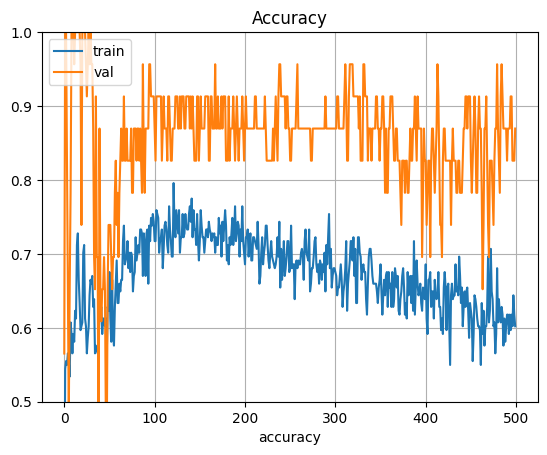

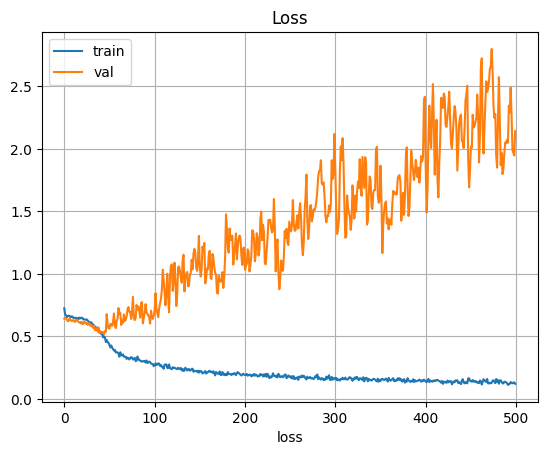

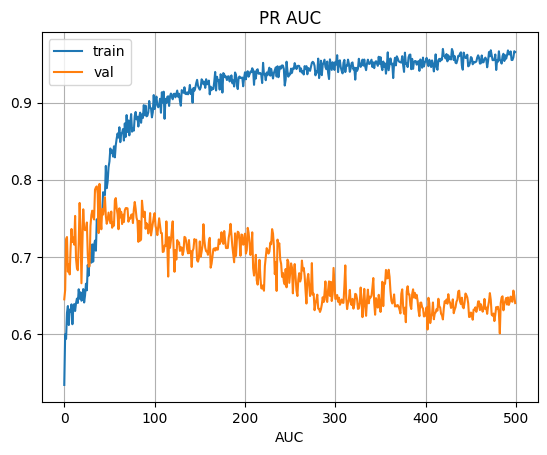

1/1 [==============================] - 0s 50ms/step - loss: 0.8949 - acc: 0.6800 - auc: 0.8379 - prec: 0.8736 - rec: 0.8352


In [17]:
### transformer-based model ###

# create datasets
batch_size = 32

# sorry for the ugly code
[[train_email_titles, train_email_bodies, train_y],
[valid_email_titles, valid_email_bodies, valid_y],
[test_email_titles, test_email_bodies, test_y]] = train_valid_test_split([email_titles, email_bodies, email_types], 0.8, 0.1, 32)

# transformer block: https://keras.io/examples/nlp/text_classification_with_transformer/
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential( # TODO: what does this do
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# create model
def build_model(subject_length, body_length, embedding, num_factors):
    # inputs
    subjectInput = layers.Input(shape = (subject_length,))
    bodyInput = layers.Input(shape = (body_length,))
    
    # # subject analysis # FIXME: UNCOMMENT
    # x_subj = pretrained_embedding(embedding)(subjectInput) # DON'T CHANGE
    # x_subj = layers.BatchNormalization()(x_subj)
    # # single directional GRU should be enough
    # x_subj = layers.GRU(subject_length)(x_subj)
    # # note: for GRU, the default tanh activation is highly optimized for GPU. uses cudnn
    # x_subj = layers.Dense(4, activation = 'relu')(x_subj) # very sus

    # # subject analysis
    # x_subj = pretrained_embedding(embedding)(subjectInput)
    # x_subj = layers.BatchNormalization()(x_subj)
    # x_subj = layers.Bidirectional(
    #     layers.GRU(subject_length)
    # )(x_subj)
    # x_subj = layers.Dense(4, activation = 'relu')(x_subj)

    # # body analysis
    # x_body = pretrained_embedding(embedding)(bodyInput)
    # x_body = layers.BatchNormalization()(x_body)
    # x_body = layers.Bidirectional(
    #     layers.GRU(body_length)
    # )(x_body)
    # x_body = layers.Dense(32, activation = 'relu')(x_body)

    # transformer body analysis
    x_body = pretrained_embedding(embedding)(bodyInput) # DON'T CHANGE
    x_body = TransformerBlock(embed_dim = 50, num_heads = 200, ff_dim = 32)(x_body) 
    # TODO: 32 literally copied from the guide. I'm not sure about the effect
    x_body = layers.GlobalAveragePooling1D()(x_body) # TODO: no idea what this does either
    x_body = layers.Dropout(0.1)(x_body)
    x_body = layers.Dense(32, activation = 'relu')(x_body)
    x_body = layers.Dropout(0.1)(x_body)

    # stitch them together...
    # x = layers.Concatenate()([x_subj, x_body]) # FIXME: UNCOMMENT
    x = layers.Dropout(0.5)(x_body) # FIXME: UNCOMMENT
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(num_factors)(x) # from logits true will automatically add the sigmoid

    model = keras.models.Model(
        inputs = [subjectInput, bodyInput],
        outputs = x,
    )

    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits = True),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[
            'acc',
            # pr curve area - should help with imbalanced data
            keras.metrics.AUC(curve='PR', name='auc'),
            # keras.metrics.TruePositives(name = 'tp'),
            # keras.metrics.FalsePositives(name = 'fp'),
            # keras.metrics.TrueNegatives(name = 'tn'),
            # keras.metrics.FalseNegatives(name = 'fn'),
            keras.metrics.Precision(name='prec'),
            keras.metrics.Recall(name='rec'),
        ],
    )

    return model 

multilabel_model = build_model(
    subject_length = SUBJECT_LEN,
    body_length = SEQUENCE_LEN,
    embedding = embedding,
    num_factors = NUM_FACTORS
)

multilabel_model = train_and_evaluate(
    model = multilabel_model,
    train_ds = ([train_email_titles, train_email_bodies], train_y),
    test_ds = ([test_email_titles, test_email_bodies], test_y),
    valid_ds = ([valid_email_titles, valid_email_bodies], valid_y),
    epochs = 500,
    batch_size = 32,
)

In [ ]:
# type((train_x, train_y)) is tuple